## 5 - Regressão

Este notebook usa a base de eventos (`data/eventos/eventos_completo.csv`) como entrada para modelos de regrassão que correlacionam a ocorrência dos acidentes com congestionamentos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import statsmodels.api as sm

In [2]:
df = pd.read_csv('data/eventos/eventos_completo.csv')
df['momento_inicial'] = pd.to_datetime(df['momento_inicial'])
df['momento_final'] = pd.to_datetime(df['momento_final'])

df['hora_inicial'] = pd.to_datetime(df['hora_inicial'], format='%H:%M:%S')
df['hora_acidente'] = pd.to_datetime(df['hora_acidente'], format='%H:%M:%S')

# Extrair a hora dos registros
df['hora_inicial_int'] = df['hora_inicial'].dt.hour
df['hora_final_int'] = df['momento_final'].dt.hour
df['hora_acidente_int'] = df['hora_acidente'].dt.hour
df['duracao'] = (df['momento_final'] - df['momento_inicial']).dt.total_seconds() / (60*60)

# Criando uma nova coluna 'mes_ano' para agrupar por mês
df['mes_ano'] = df['momento_inicial'].dt.to_period('M')

df['hora_float'] = df['hora_inicial'].dt.hour * 60 + df['hora_inicial'].dt.minute
df['hora_int'] = df['hora_inicial'].dt.hour
df['tamanho_km_int'] = df['tamanho'].apply(lambda x : round(x / 1000))

print(len(df)) # 100391

83317


In [3]:
df.sample(3)

,Unnamed: 0.1,Unnamed: 0,cluster,momento_inicial,momento_final,duracao,dia_semana,hora_inicial,tamanho,n_vertices,...,tipo_acidente,qtde_vitimas,hora_acidente,hora_inicial_int,hora_final_int,hora_acidente_int,mes_ano,hora_float,hora_int,tamanho_km_int
13123,3,3,-21,2019-09-01 07:38:00,2019-09-01 07:38:00,0.0,6,1900-01-01 07:38:00,0.0,2,...,1.0,1.0,1900-01-01 07:38:00,7,7,7.0,2019-09,458,7,0
3867,745,745,-15,2019-03-16 17:58:00,2019-03-16 17:58:00,0.0,5,1900-01-01 17:58:00,0.0,2,...,1.0,1.0,1900-01-01 17:58:00,17,17,17.0,2019-03,1078,17,0
55018,31,31,-5,2022-05-02 20:29:00,2022-05-02 20:29:00,0.0,0,1900-01-01 20:29:00,0.0,2,...,0.0,1.0,1900-01-01 20:29:00,20,20,20.0,2022-05,1229,20,0


### Formatação da variável de saída (acidente)

In [4]:
def valor_gravidade_acidente(tipo_acidente, qtde_vitimas):
    # sem acidente
    if tipo_acidente == 0: return 0 # sem acidente

    # incidente de transito (apenas danos materiais)
    if tipo_acidente == 1 and qtde_vitimas == 0: # nao_fatal
        return 1
    # sinistro sem vitimas
    if qtde_vitimas == 0:
        return 2
    # sinistro com vitimas nao fatal
    if tipo_acidente < 3:
        return 3
    # sinistro com vitima fatal
    return 4


def variavel_saida(tipo_acidente, qtde_vitimas, n_acidentes):
    if qtde_vitimas > 1 or n_acidentes > 1:
        c = compensacao_quantidade(qtde_vitimas + n_acidentes)
    else: c = 0

    g = valor_gravidade_acidente(tipo_acidente, qtde_vitimas)
    valor_gravidade = g / 4.4
    return min(1, valor_gravidade + c)

def compensacao_quantidade(n):
    return ((n) / 6) * 0.25

df['qtde_vitimas_limitado'] = df['qtde_vitimas'].apply(lambda q : min(q, 3))
df['n_acidentes_limitado'] = df['n_acidentes'].apply(lambda a : min(a, 3))
df['acidentes_e_vitimas'] = df['n_acidentes_limitado'] + df['qtde_vitimas_limitado']
df['tipo_acidente_extendido'] = df.apply(lambda e : e['tipo_acidente'] + 1 if e['n_acidentes'] > 0 else 0, axis = 1)
df['gravidade_acidente'] = df.apply(lambda e : valor_gravidade_acidente(e['tipo_acidente_extendido'], e['qtde_vitimas_limitado']), axis = 1)

df['variavel_dependente'] = df.apply(lambda e : variavel_saida(e['tipo_acidente_extendido'], e['qtde_vitimas_limitado'], e['n_acidentes_limitado']), axis = 1)
df['variavel_dependente_binario'] = df.apply(lambda e : min(1, e['n_acidentes']), axis = 1)

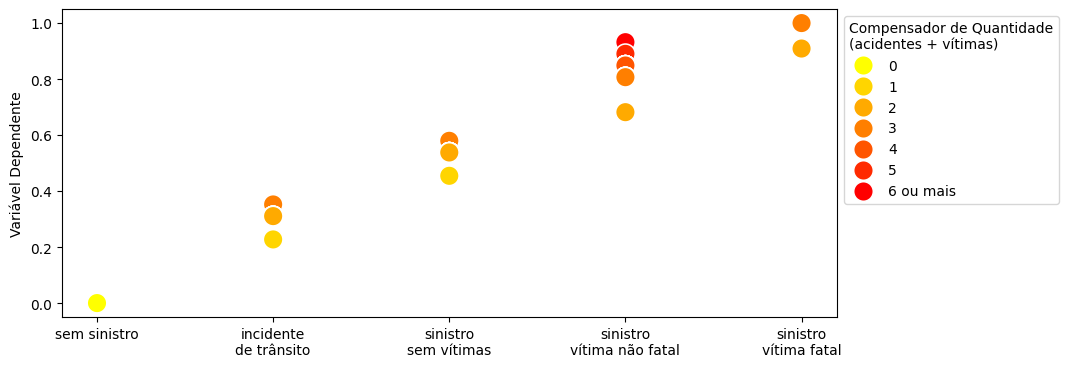

In [5]:
plt.figure(figsize=(10, 4))

sns.scatterplot(data=df, x='gravidade_acidente', y='variavel_dependente', hue='acidentes_e_vitimas', palette='autumn_r', s=200)
#plt.title('Disperção da variável de saída')
plt.xticks(range(5), ['sem sinistro', 'incidente\nde trânsito', 'sinistro\nsem vítimas', 'sinistro\nvítima não fatal', 'sinistro\nvítima fatal'])
plt.xlabel('')
plt.ylabel('Variável Dependente')
handles, labels = plt.gca().get_legend_handles_labels()
labels = ['0', '1', '2', '3', '4', '5', '6 ou mais']
plt.legend(handles, labels, title='Compensador de Quantidade\n(acidentes + vítimas)', loc='upper left', bbox_to_anchor=(1, 1), frameon=True, alignment='left')
plt.show()

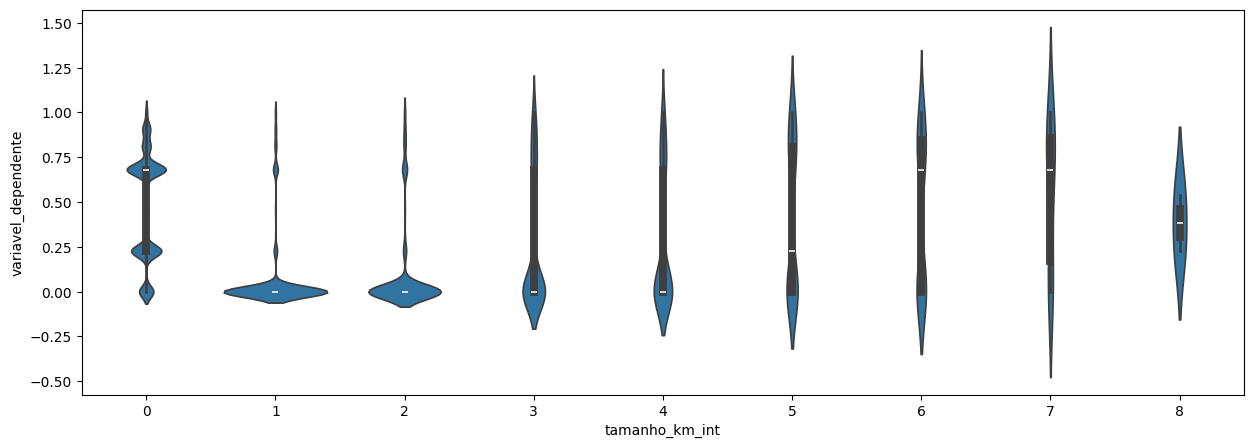

In [6]:

plt.figure(1, (15, 5))
#sns.scatterplot(data=df, x='tamanho', y='variavel_dependente', hue='duracao', palette='autumn')
#sns.violinplot(data=df, x='dia_semana', y='variavel_dependente', palette='autumn')
#sns.scatterplot(data=df, x='hora_float', y='variavel_dependente', hue='dia_semana', palette='autumn')
#sns.violinplot(data=df, x='hora_int', y='variavel_dependente')
sns.violinplot(data=df, x='tamanho_km_int', y='variavel_dependente')
plt.show()

## A Regressão

#### Funções para execução e visualização

In [7]:
def grid_pontos_real(df, coluna, n_grid_x = 100, n_grid_y = 100):
    global colunas
    ci = colunas[coluna]

    xs = []
    ys = []
    ss = []
    n_grid = 100
    intervalo_x = df[coluna].max() / n_grid_x
    intervalo_y = 1 / n_grid_y

    x_linspace = np.linspace(df[coluna].min(), df[coluna].max(), n_grid_x)
    y_linspace = np.linspace(0, 1, n_grid_y)

    i = 0
    for y_i in y_linspace:
        df_yi = df[(df['variavel_dependente'] >= y_i) & (df['variavel_dependente'] < y_i + intervalo_y)]

        if not df_yi.empty:  # Evitar processamento se o df estiver vazio
            for x_i in x_linspace:
                s = len(df_yi[(df_yi[coluna] >= x_i) & (df_yi[coluna] < x_i + intervalo_x)])
                if s > 0:
                    xs.append(x_i)
                    ys.append(y_i)
                    ss.append(s)

    m = max(ss)
    for i in range(len(ss)):
        ss[i] = .5 + ((ss[i] / m) * 500)
            
    return xs, ys, ss

In [8]:
def realiza_predicao(X, scaler, modelo, poly, coluna, n_grid):
    global colunas

    X_c = [x[colunas[coluna]] for x in X]
    min_x = min(X_c)
    max_x = max(X_c)
    margem = (max_x - min_x) / 10
    min_x -= margem
    max_x += margem
    X_range = np.linspace(min_x, max_x, n_grid).reshape(-1, 1)  # 100 pontos no intervalo de X



    dados = [[0,0,0,0,0,0] for _ in range(len(X_range))] 
    for i in range(len(X_range)):
        dados[i][colunas[coluna]] = X_range[i][0]

    X_df = pd.DataFrame(dados)
    X_range_poly = poly.transform(X_df)  # Transformar para características polinomiais
    y_predito = modelo.predict(X_range_poly)

    original = scaler.inverse_transform(dados)
    x_predito = np.linspace(original[0][colunas[coluna]], original[-1][colunas[coluna]], n_grid)
    
    return x_predito, y_predito

In [9]:
def treina_modelo(X_train, X_test, y_train, y_test, grau_polinomio):
    poly = PolynomialFeatures(degree=grau_polinomio)  # Grau do polinômio
    X_train_poly = poly.fit_transform(X_train)  # Transformar o conjunto de treino
    X_test_poly = poly.transform(X_test)  # Transformar o conjunto de teste

    modelo = LinearRegression()
    modelo.fit(X_train_poly, y_train)
    
    y_pred = modelo.predict(X_test_poly)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return modelo, poly, mse, r2

In [10]:
colunas = {'duracao': 0, 'dia_semana': 1, 'hora_float': 2, 
           'tamanho': 3, 'n_vertices': 4, 'media_grau': 5}

def plota_regressao_coluna(df, coluna, graus = range(1, 5), n_grid = 100):
    global colunas

    scaler = StandardScaler()
    X = df.drop('variavel_dependente', axis=1)
    X = scaler.fit_transform(X.values)
    y = df['variavel_dependente']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    x_real, y_real, size_real = grid_pontos_real(df, coluna, n_grid)

    # Criando subplots para os três graus de polinômio
    fig, axes = plt.subplots(1, len(graus), figsize=(18, 6))  # 1 linha, 3 colunas
    
    for grau_polinomio, ax in zip(graus, axes):
        modelo, poly, mse, r2 = treina_modelo(X_train, X_test, y_train, y_test, grau_polinomio)
        x_predito, y_predito = realiza_predicao(X, scaler, modelo, poly, coluna, n_grid)

        ax.scatter(x_real, y_real, color='blue', s=size_real, alpha=0.7)
        ax.plot(x_predito, y_predito, color='red')
        ax.set_xlabel(coluna)
        ax.set_ylabel('Variável Dependente')
        ax.set_ylim(-0.2, 1.2)
        ax.set_title(f'Regressão Polinomial (Grau {grau_polinomio})')
        ax.legend(labels=['Dados reais', f'Regressão (grau {grau_polinomio})'], loc='upper right')

        textstr = f'MSE: {mse:.4f}\nR²: {r2:.4f}'
        props = dict(boxstyle='round', facecolor='white', alpha=0.8)

        # Definindo a posição relativa da caixa de texto abaixo da legenda
        ax.text(0.025, 0.975, textstr, transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', bbox=props)

    plt.tight_layout()  # Ajusta o espaçamento entre os gráficos
    plt.show()

## Análise dos Resultados

### Visualização das Curvas

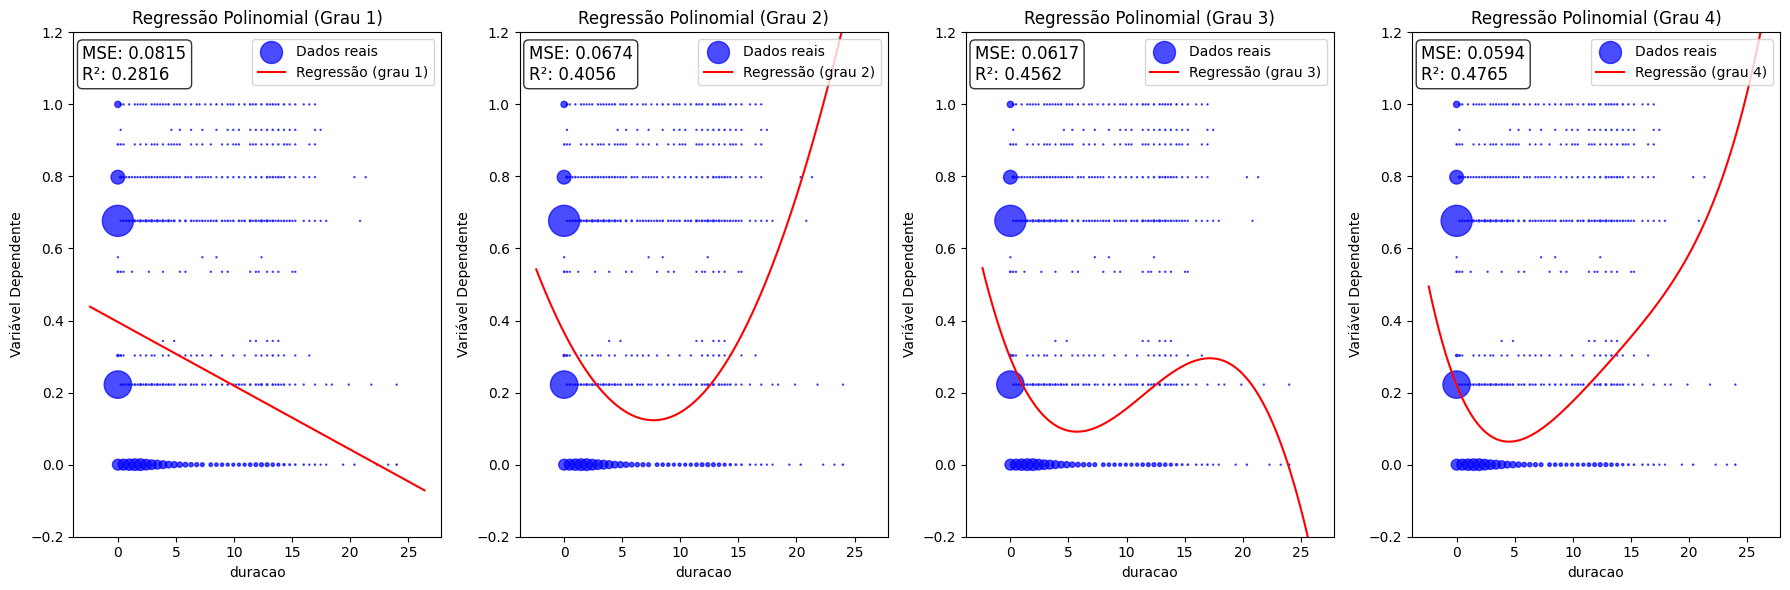

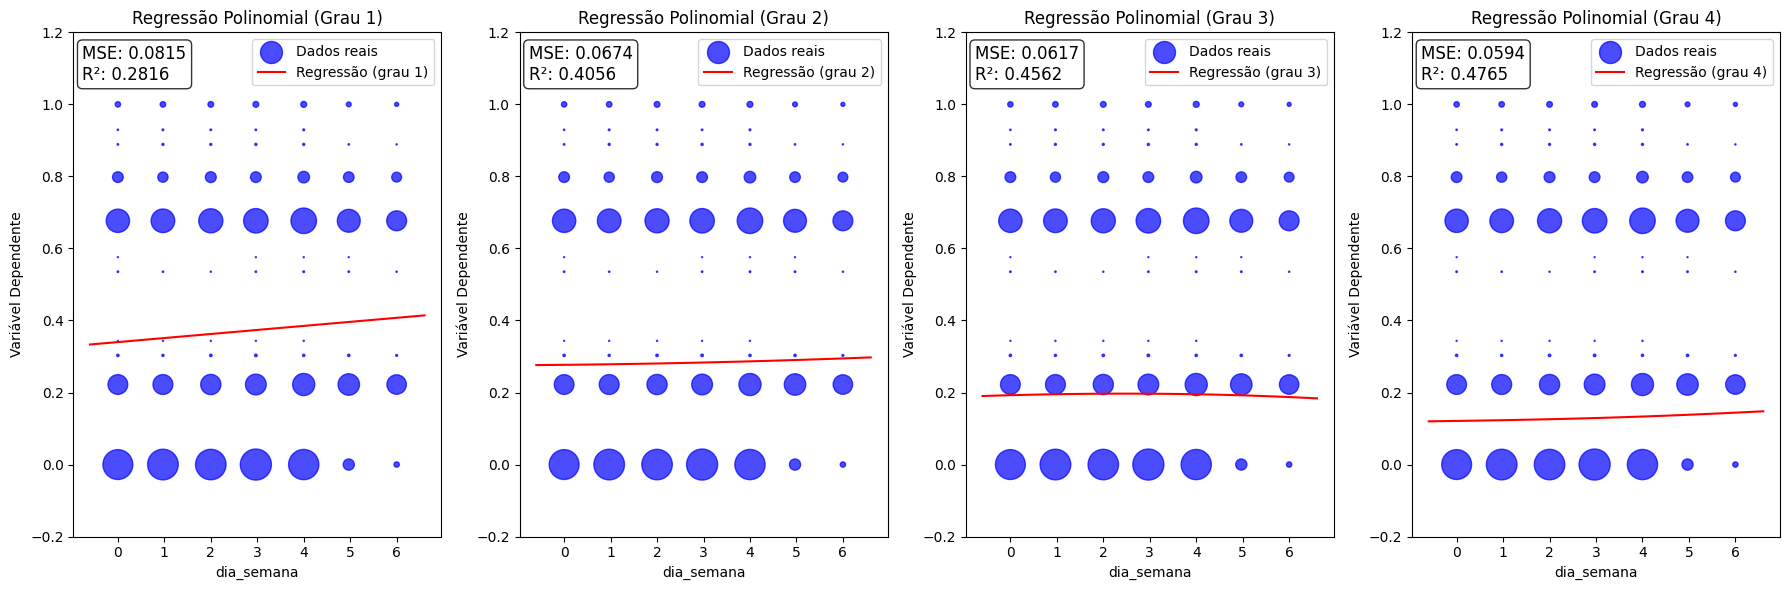

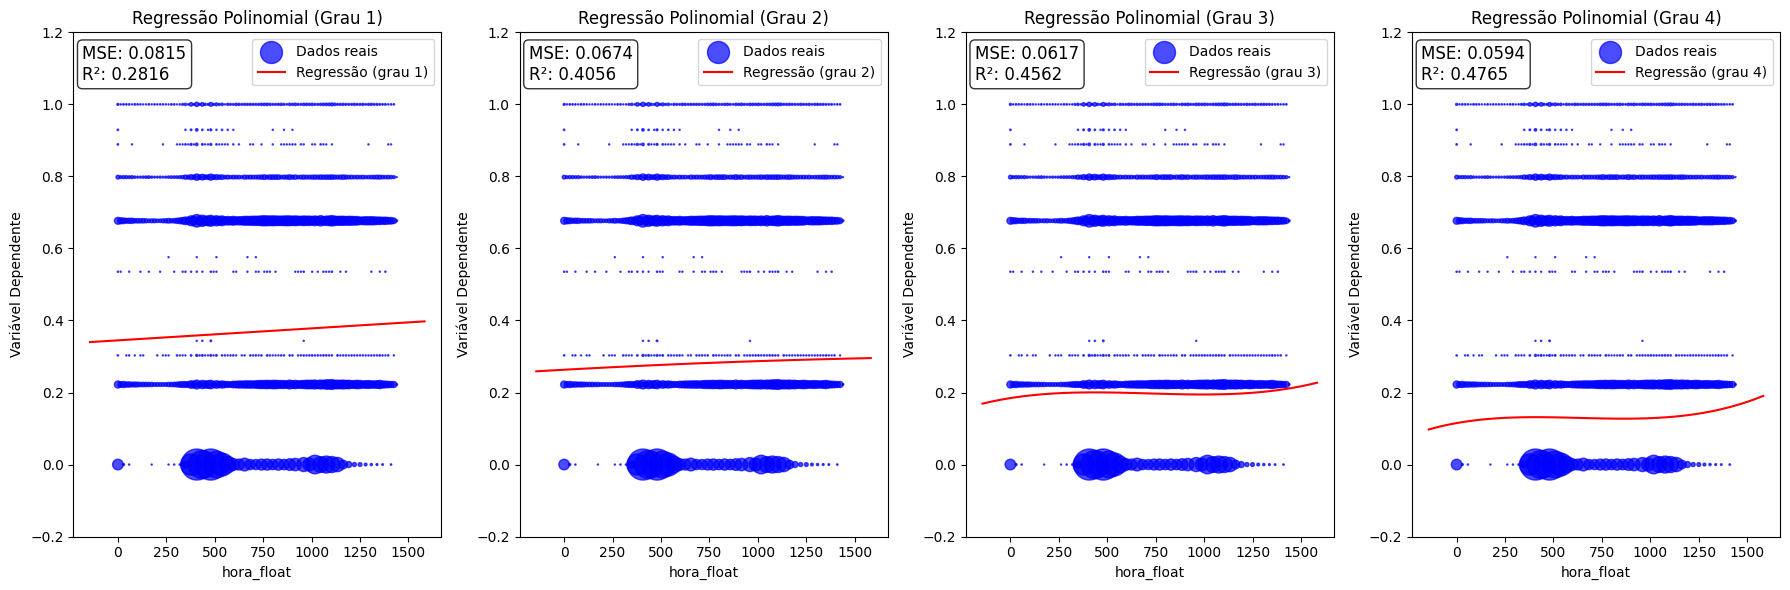

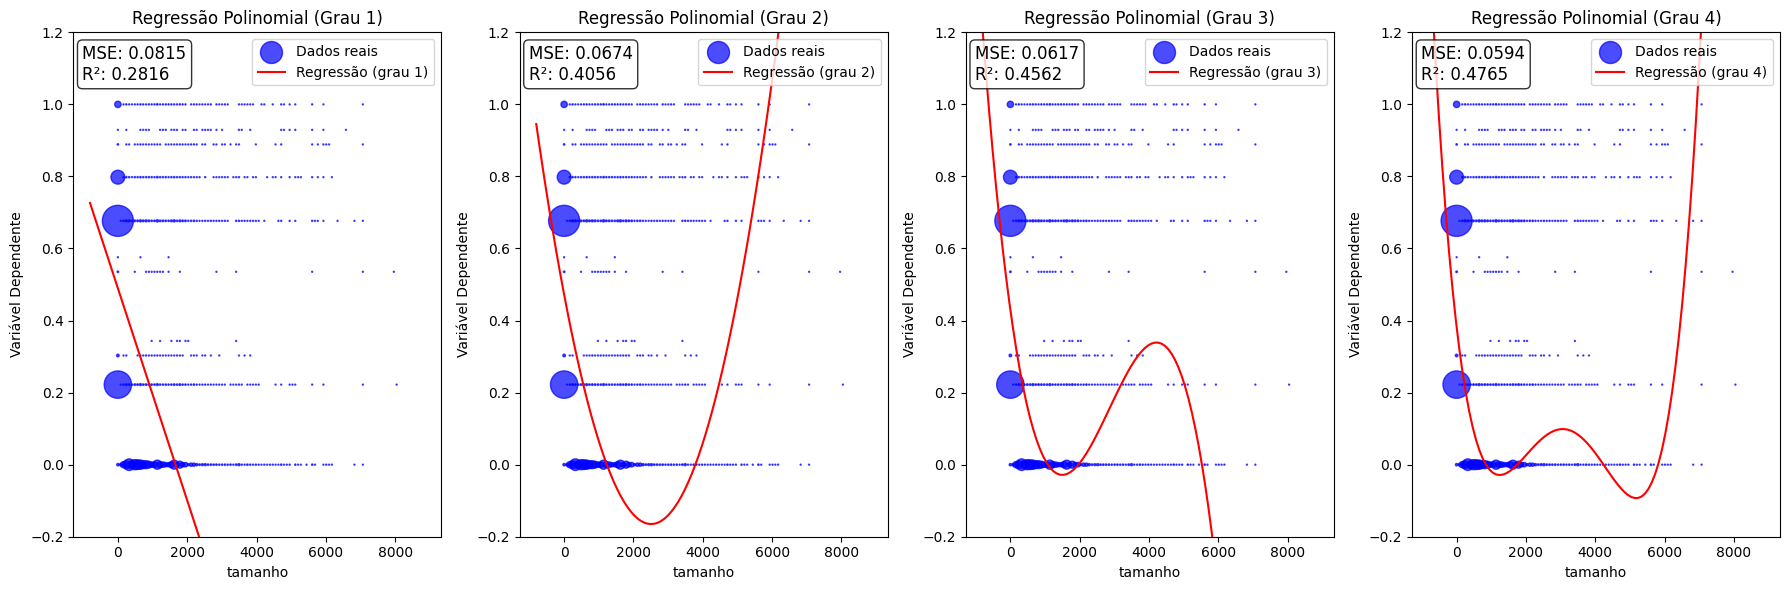

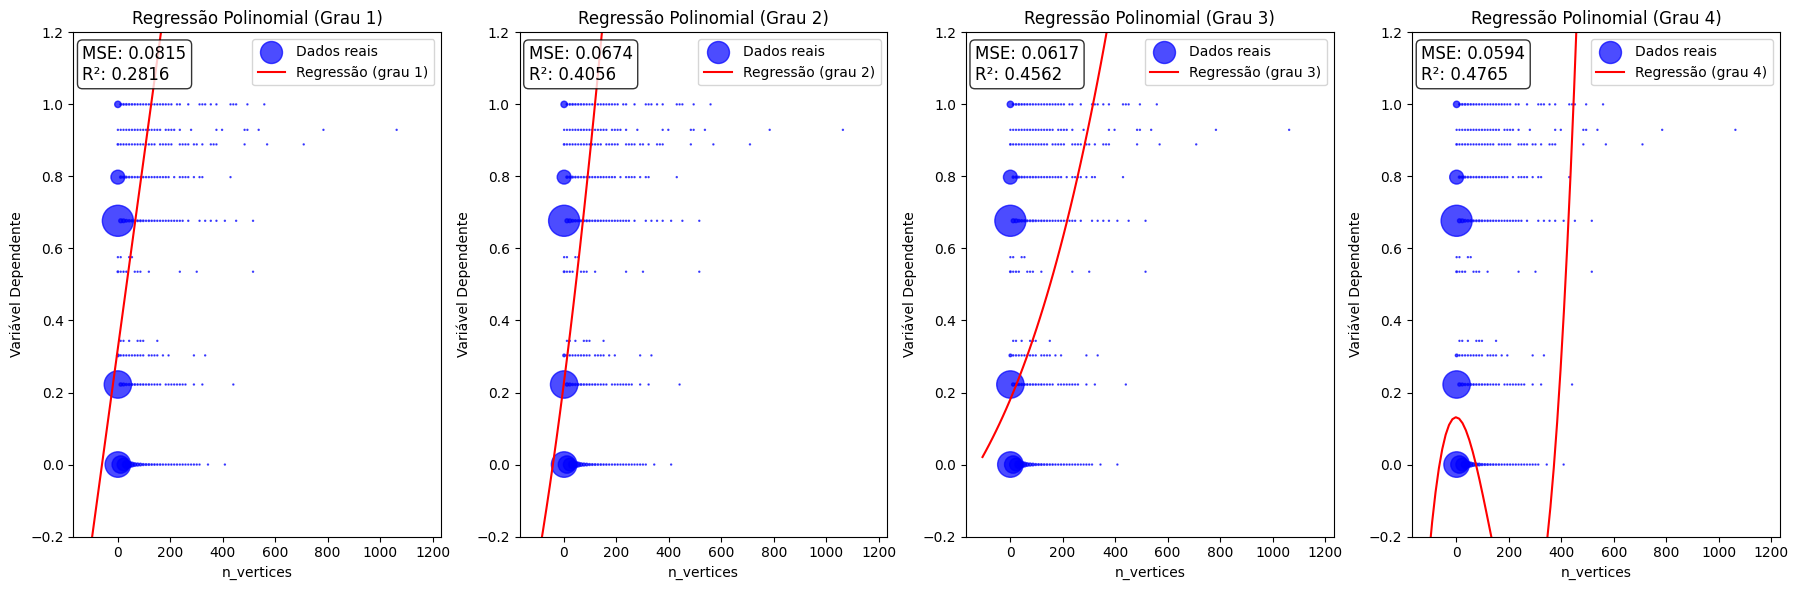

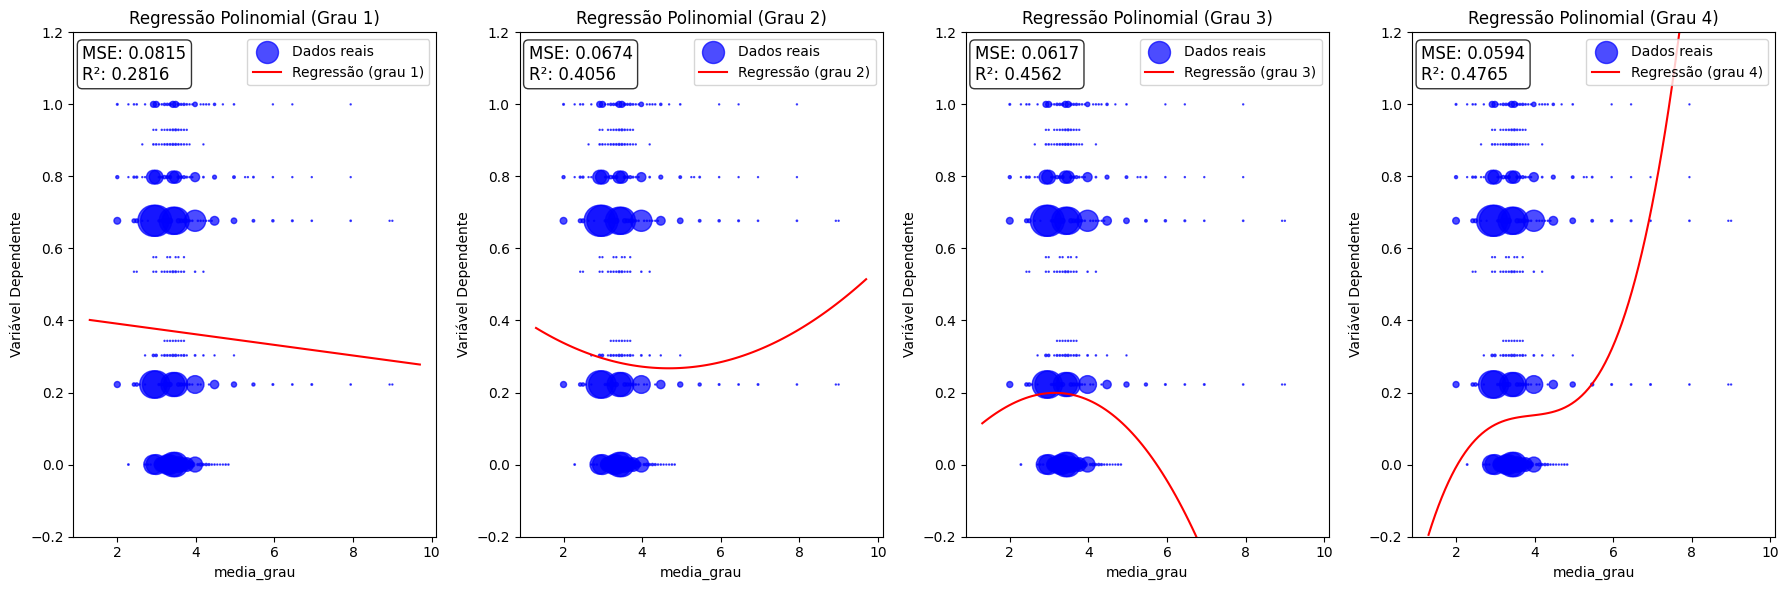

In [11]:
df_final = df[['duracao', 'dia_semana', 'hora_float', 'tamanho', 'n_vertices', 'media_grau', 'variavel_dependente']]
df_final.reset_index()
df_final.head(3)

graus = [1, 2, 3, 4]
for c in colunas.keys():
    plota_regressao_coluna(df_final, c, graus, n_grid = 100)

3793


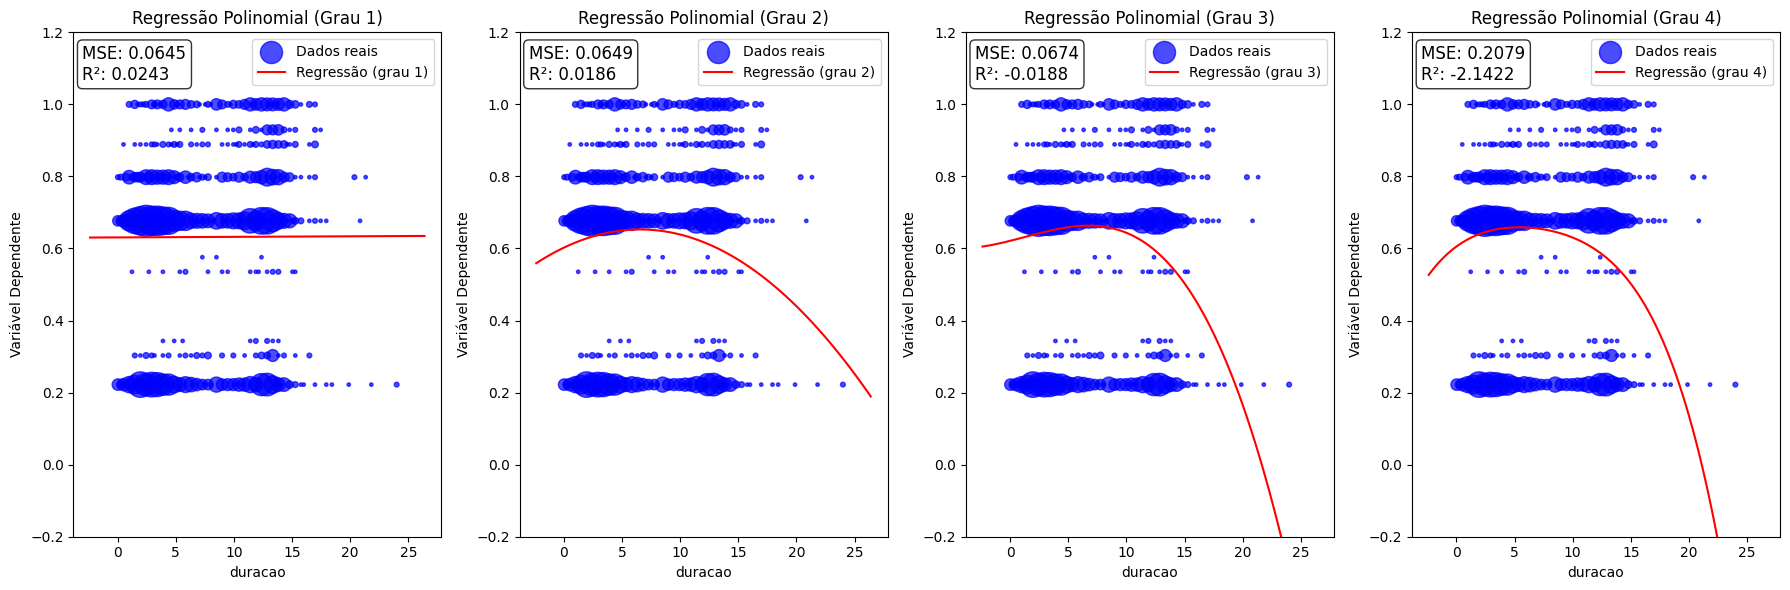

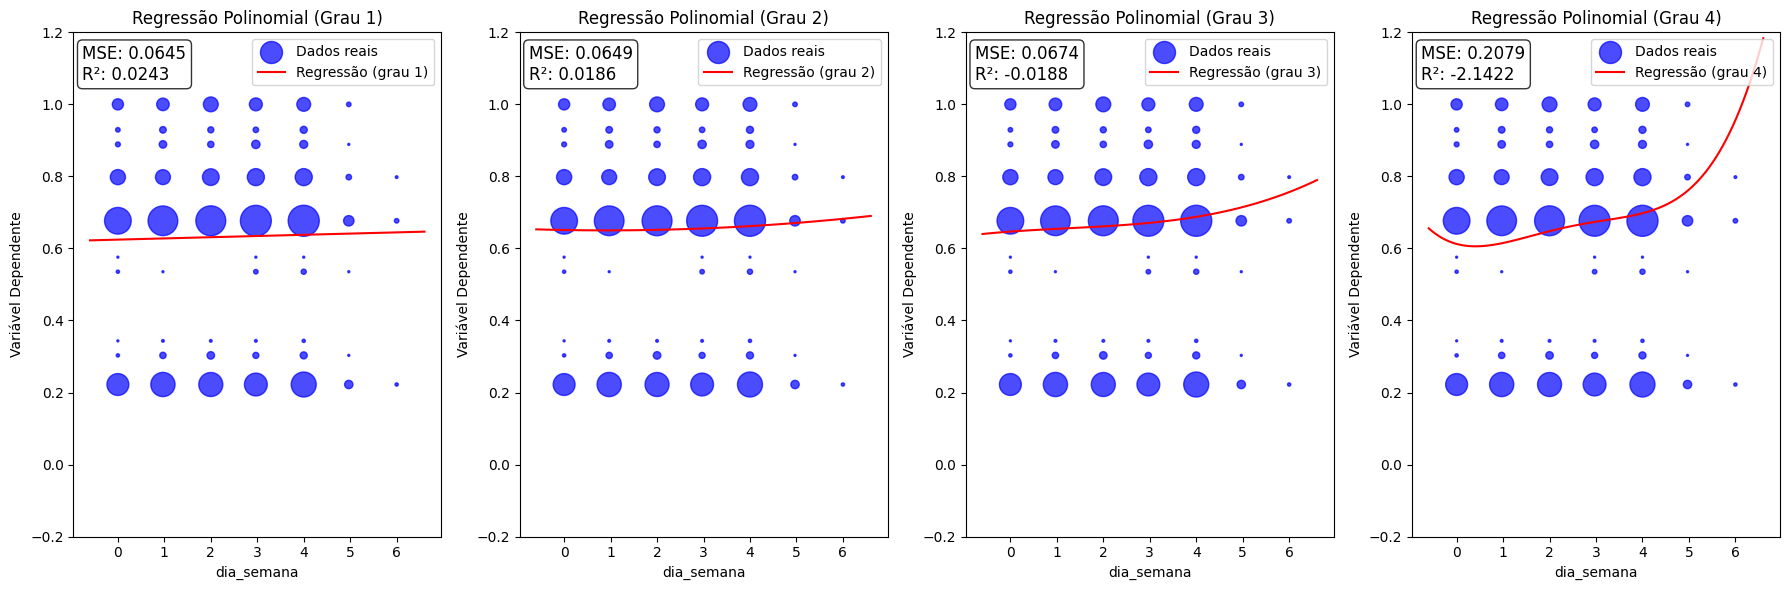

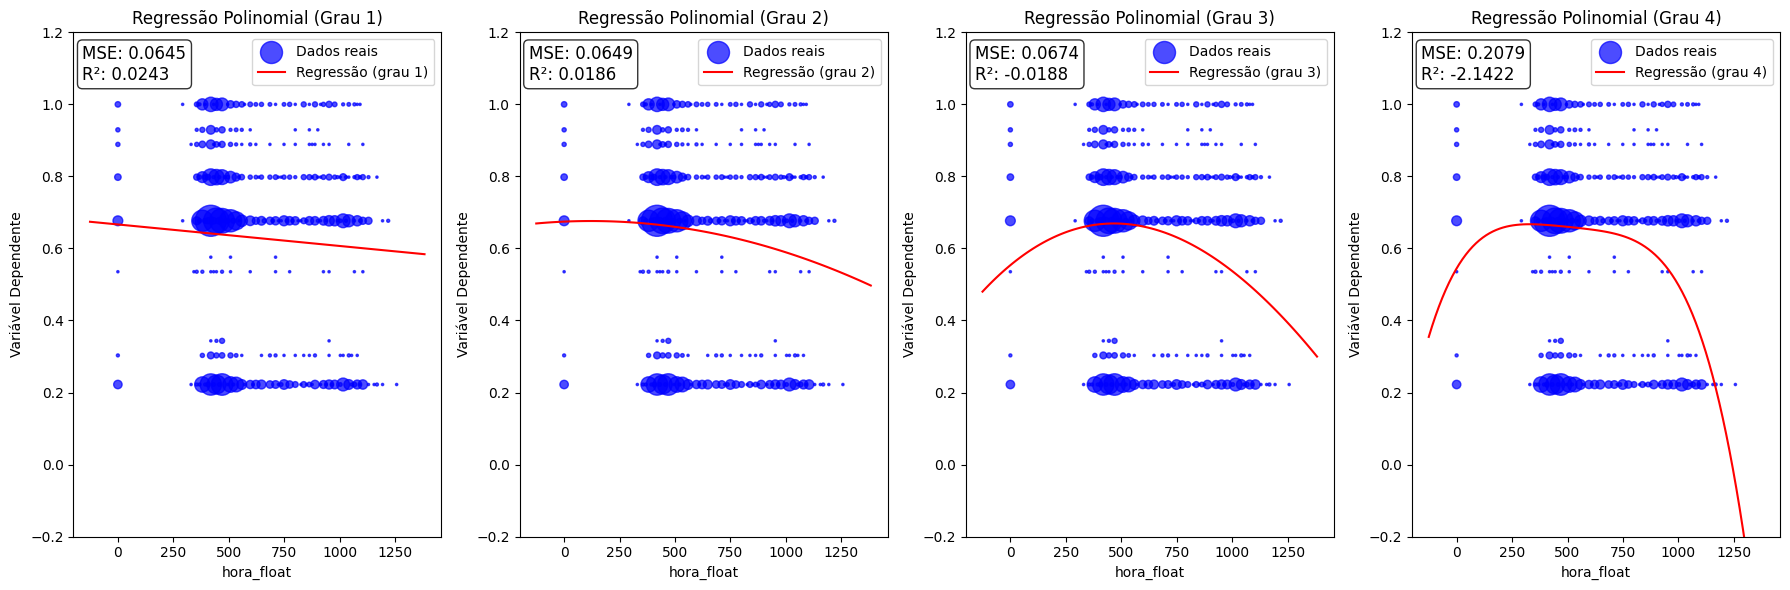

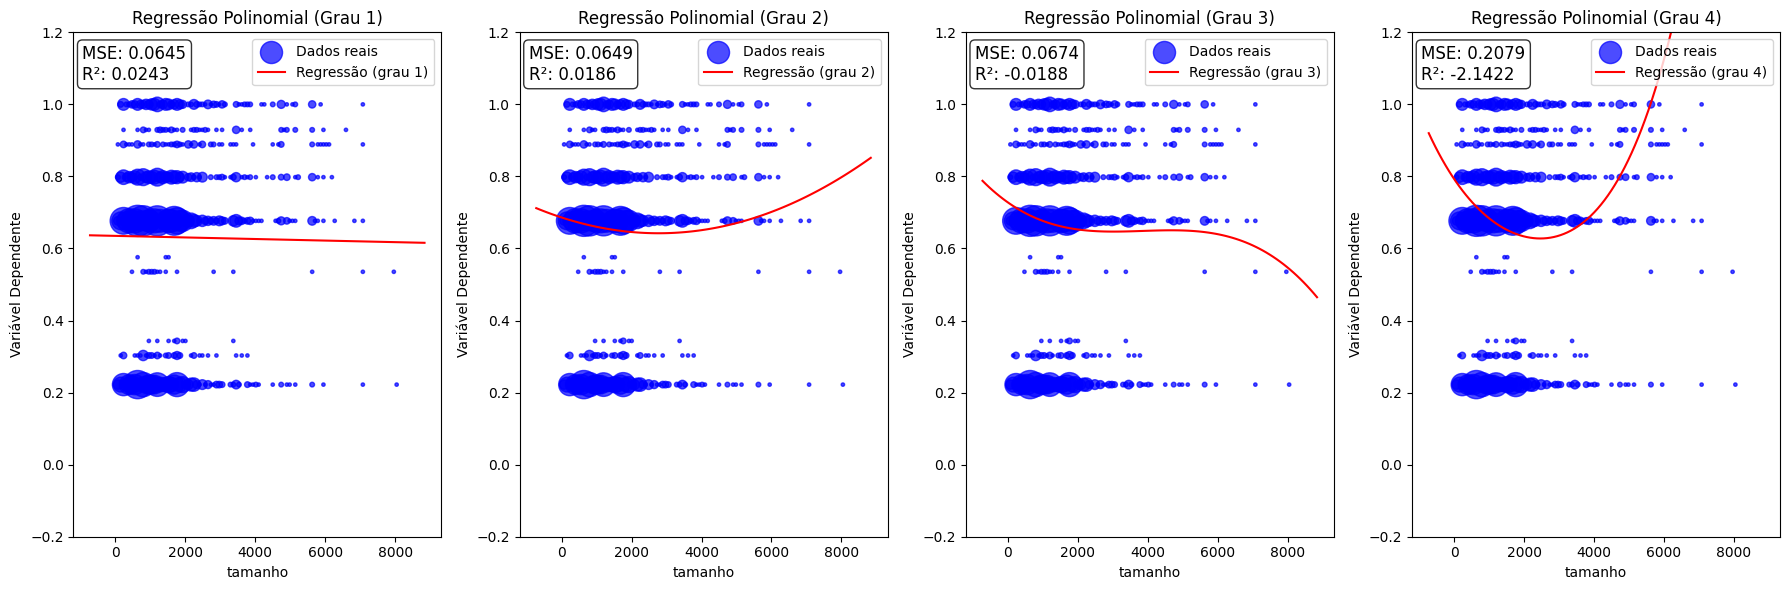

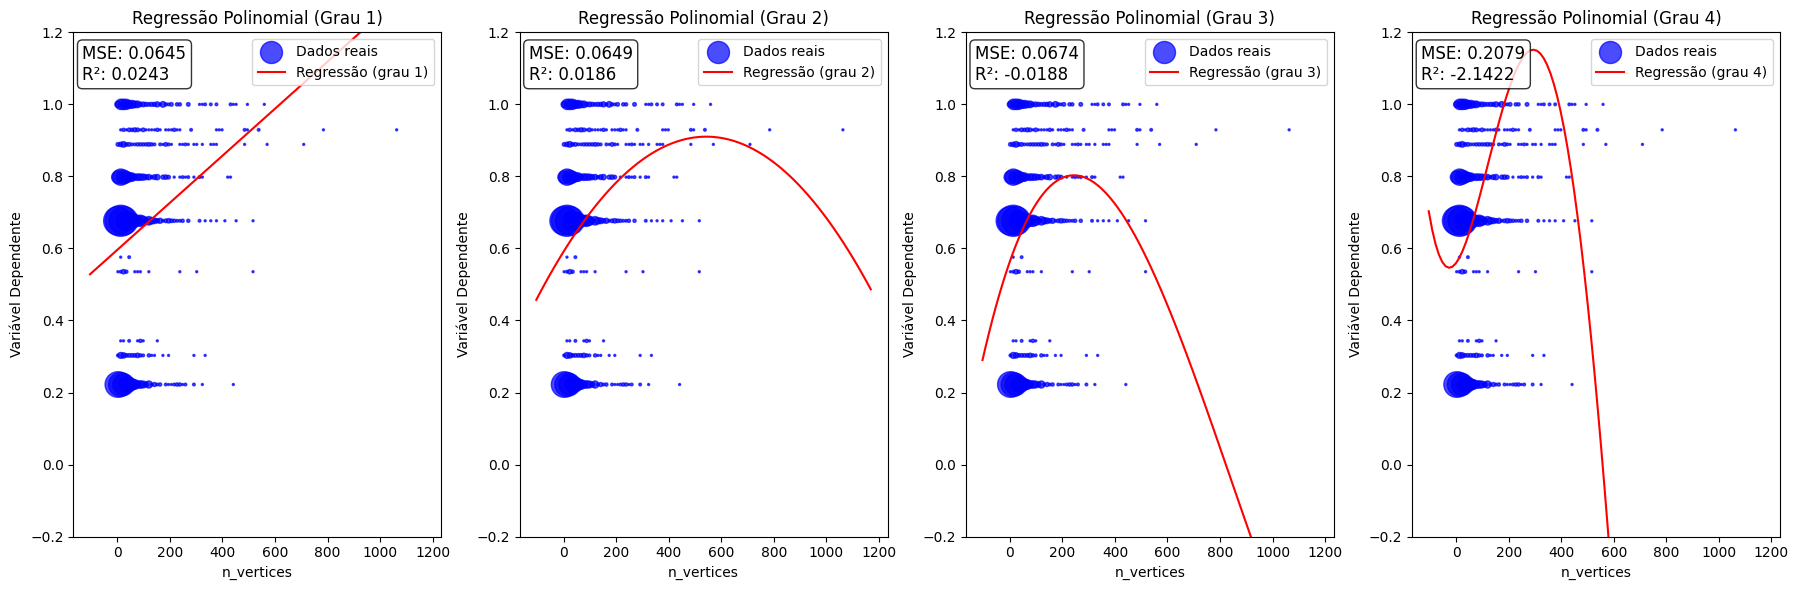

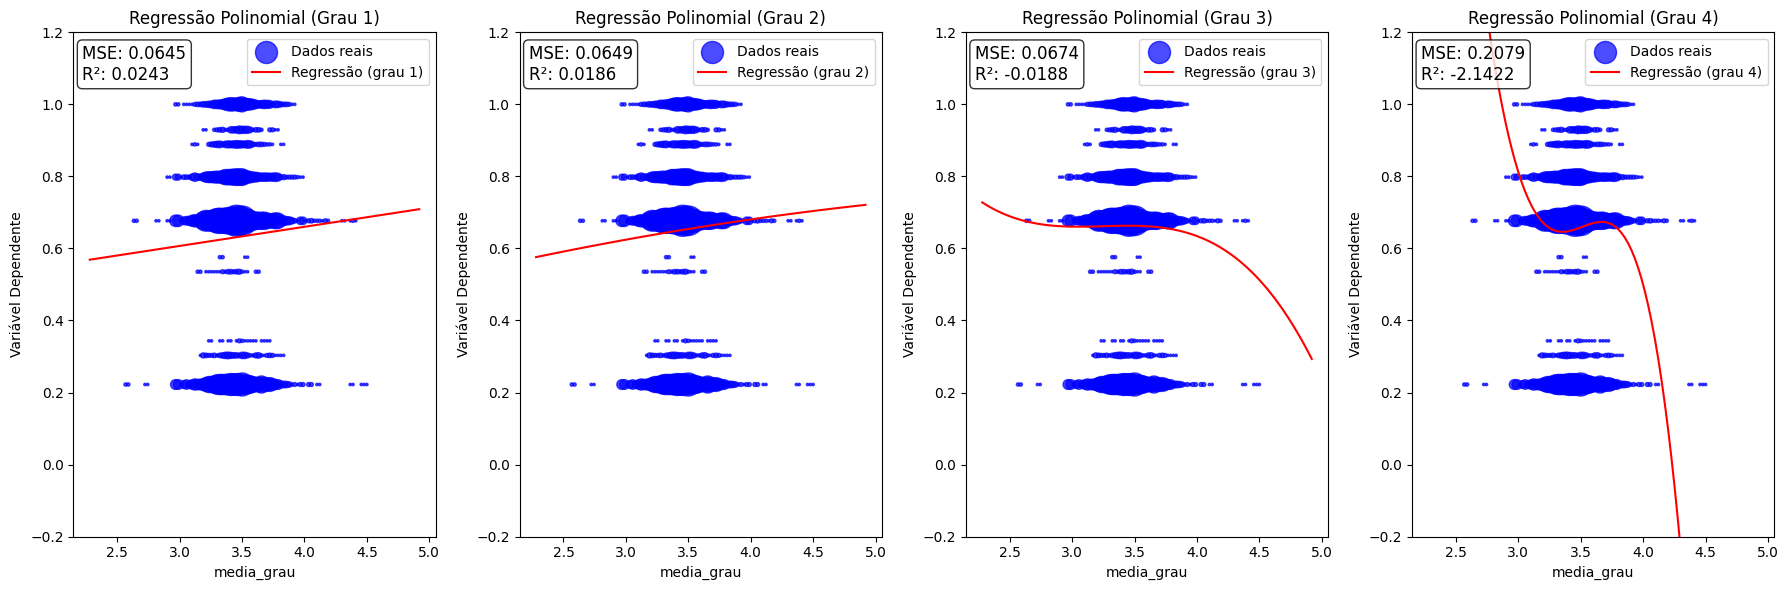

In [12]:
df_aci_cong = df_final.query('tamanho > 0 and variavel_dependente > 0')
print(len(df_aci_cong))
for c in colunas.keys():
    graus = [1, 2, 3, 4]
    plota_regressao_coluna(df_aci_cong, c, graus, n_grid = 100)

In [17]:
scaler = StandardScaler()
X = df_final.drop('variavel_dependente', axis=1)
X = scaler.fit_transform(X.values)
y = df_final['variavel_dependente']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [18]:
modelo, poly, mse, r2 = treina_modelo(X_train, X_test, y_train, y_test, grau_polinomio = 1)

df_coef = pd.DataFrame(modelo.coef_)
df_coef.index = ['intercepto'] + list(df_final.columns[:-1])
display(df_coef)
#print(poly.get_feature_names_out())
#print(modelo.coef_)

,0
intercepto,0.000000
duracao,-0.052882
dia_semana,0.020539
hora_float,0.011226
tamanho,-0.203204
n_vertices,0.123364
media_grau,-0.006877


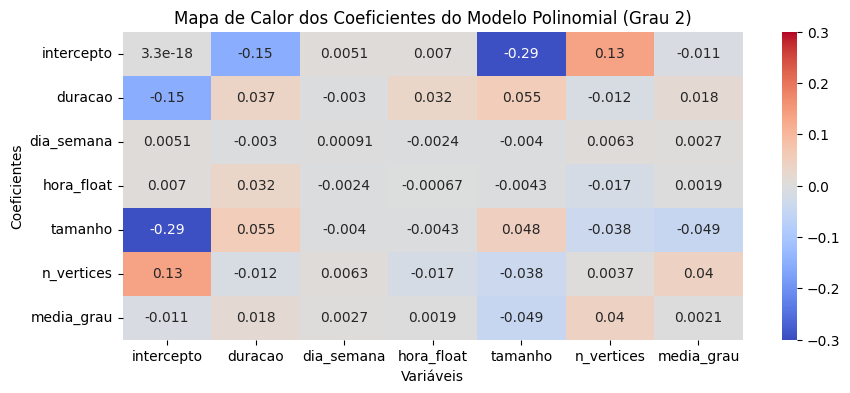

,intercepto,duracao,dia_semana,hora_float,tamanho,n_vertices,media_grau
intercepto,3.299516e-18,-0.152765,0.005079,0.007025,-0.293483,0.134891,-0.011362
duracao,-1.527652e-01,0.036686,-0.003040,0.031581,0.055460,-0.011727,0.017900
dia_semana,5.078521e-03,-0.003040,0.000910,-0.002387,-0.004015,0.006320,0.002714
hora_float,7.024878e-03,0.031581,-0.002387,-0.000672,-0.004299,-0.016761,0.001943
tamanho,-2.934831e-01,0.055460,-0.004015,-0.004299,0.048151,-0.038422,-0.049090
n_vertices,1.348913e-01,-0.011727,0.006320,-0.016761,-0.038422,0.003732,0.040294
media_grau,-1.136177e-02,0.017900,0.002714,0.001943,-0.049090,0.040294,0.002137


['1' 'x0' 'x1' 'x2' 'x3' 'x4' 'x5' 'x0^2' 'x0 x1' 'x0 x2' 'x0 x3' 'x0 x4'
 'x0 x5' 'x1^2' 'x1 x2' 'x1 x3' 'x1 x4' 'x1 x5' 'x2^2' 'x2 x3' 'x2 x4'
 'x2 x5' 'x3^2' 'x3 x4' 'x3 x5' 'x4^2' 'x4 x5' 'x5^2']


In [19]:
modelo, poly, mse, r2 = treina_modelo(X_train, X_test, y_train, y_test, grau_polinomio = 2)


coef = [[0] * 7 for _ in range(7)]
coef[0][0] = 3

i = 0
j = 0
for c in range(len(modelo.coef_)):
    modelo.coef_[c]
    coef[i][j] = modelo.coef_[c]
    coef[j][i] = modelo.coef_[c]

    j += 1
    if j == 7: 
        i += 1
        j = i

df_coef = pd.DataFrame(coef)
df_coef.index = ['intercepto'] + list(df_final.columns[:-1])
df_coef.columns = ['intercepto'] + list(df_final.columns[:-1])

# Plot do mapa de calor
plt.figure(figsize=(10, 4))
sns.heatmap(df_coef, annot=True, cmap="coolwarm", cbar=True, vmin=-0.3, vmax=0.3)
plt.title('Mapa de Calor dos Coeficientes do Modelo Polinomial (Grau 2)')
plt.xlabel('Variáveis')
plt.ylabel('Coeficientes')
plt.show()

#df_coef.index = ['intercepto'] + list(df_final.columns[:-1])
display(df_coef)
print(poly.get_feature_names_out())
#print(modelo.coef_)

In [16]:
modelo, poly, mse, r2 = treina_modelo(X_train, X_test, y_train, y_test, grau_polinomio = 3)


# Obtendo os 10 maiores valores e seus índices 
maiores = sorted(enumerate(modelo.coef_), key=lambda x: abs(x[1]), reverse=True)[:15]

# Separando os índices e valores
indices, valores = zip(*maiores)

nomes = poly.get_feature_names_out()
for i in indices:
    print(f'{nomes[i]}:\t\t {round(modelo.coef_[i], 3)}')
    

x3:		 -0.315
x0:		 -0.163
x3^2:		 0.128
x0 x3:		 0.117
x0^2:		 0.073
x3 x4:		 -0.057
x3 x5:		 -0.05
x4 x5^2:		 0.047
x4:		 0.041
x4 x5:		 0.041
x3 x5^2:		 -0.037
x0 x2:		 0.036
x2 x4 x5:		 0.032
x2 x4:		 -0.031
x0 x4:		 0.029
